# Experiment: Outliers in raw data? (April 25th, 2024)

In the UMAP donor embeddings we find about 10 severe outliers.
Can we already spot them in the raw input data to justify removing them?

In [1]:
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

In [6]:
adata = ad.read_h5ad("data/adata_rosmap_v3_top1000_s3_k30_drop.h5ad")
DONORS = sorted(adata.obs["Donor ID"].unique())

In [15]:
OUTLIERS = ['11326252', '11624423', '15114174', '15144878', '20147440', '20225925', '20730959', '50101785', '50105725', '50107583']
OUTLIERS = [int(x) for x in OUTLIERS]

In [131]:
adata_no_outliers = adata[~adata.obs["Donor ID"].isin(OUTLIERS), :].copy()
adata_no_outliers.write_h5ad("data/adata_rosmap_v3_top1000_s3_k30_drop_nout.h5ad")

In [127]:
# Calculate donor embeddings by averaging cell features
d_emb = np.zeros((len(DONORS), adata.X.shape[1]))
for i, donor_id in enumerate(DONORS):
    donor_idx = adata.obs["Donor ID"] == donor_id
    d_emb[i] = adata.X[donor_idx].mean(axis=0)

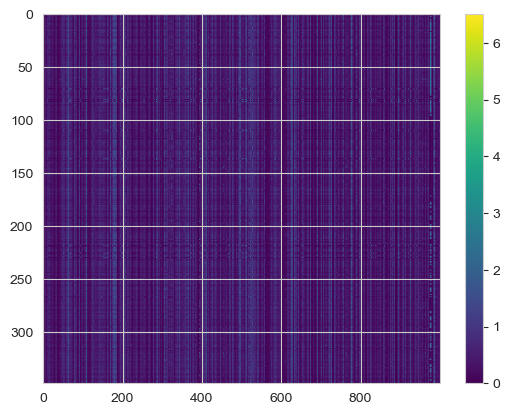

In [128]:
plt.imshow(d_emb, aspect="auto", cmap="viridis")
plt.colorbar()

In [129]:
# PCA and UMAP it
from sklearn.decomposition import PCA
from umap import UMAP

pca = PCA(n_components=50)
umap = UMAP(n_components=2, verbose=True)

d_emb_pca = pca.fit_transform(d_emb)
d_emb_umap = umap.fit_transform(d_emb_pca)

UMAP( verbose=True)
Thu Apr 25 15:51:53 2024 Construct fuzzy simplicial set
Thu Apr 25 15:51:53 2024 Finding Nearest Neighbors
Thu Apr 25 15:51:53 2024 Finished Nearest Neighbor Search
Thu Apr 25 15:51:53 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Apr 25 15:51:55 2024 Finished embedding


<Axes: >

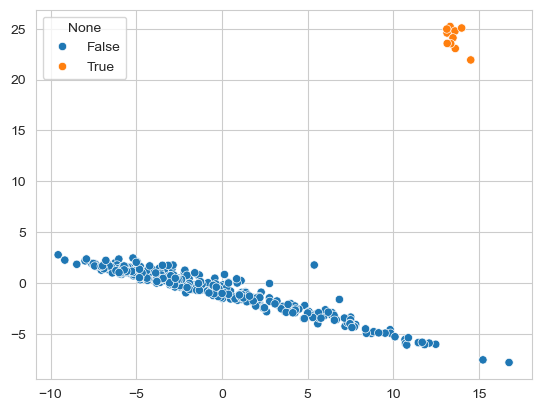

In [130]:
# plot
sns.scatterplot(x=d_emb_pca[:, 0], y=d_emb_pca[:, 1], hue=pd.Series(DONORS).isin(OUTLIERS))


In [102]:
adata.obs["cell_type_high_resolution"].value_counts(normalize=True)

cell_type_high_resolution
Oligodendrocytes              0.283330
Excitatory_neurons_set1       0.124278
Exc L3-4 RORB CUX2            0.071706
Exc L4-5 RORB IL1RAPL2        0.045442
Exc RELN CHD7                 0.045115
Ast GRM3                      0.040192
OPCs                          0.040110
Mic P2RY12                    0.032918
Exc L4-5 RORB GABRG1          0.031928
Exc L6 THEMIS NFIA            0.027018
Inh PVALB HTR4                0.019252
Exc L3-5 RORB PLCH1           0.015872
Ast DPP10                     0.014846
Inh LAMP5 NRG1 (Rosehip)      0.011891
Inh CUX2 MSR1                 0.011475
Ast CHI3L1                    0.011219
Inh RYR3 TSHZ2                0.011084
Inh L3-5 SST MAFB             0.010721
Exc L6b                       0.010283
Inh PVALB SULF1               0.009734
Exc L6 CT                     0.009558
Exc L5-6 RORB LINC02196       0.008922
Inh VIP CLSTN2                0.008018
Exc NRGN                      0.007567
Exc L5/6 IT Car3              0.007458

In [70]:
df = adata.obs.groupby("Donor ID").first()
wang_AD = np.bitwise_and(np.bitwise_and(df["ceradsc"] <= 2, df["braaksc"] >= 4), df["cogdx"] == 4)
wang_CT = np.bitwise_and(np.bitwise_and(df["ceradsc"] >= 3, df["braaksc"] <= 3), df["cogdx"] == 1)
df["wang"] = "Other"
df.loc[wang_AD, "wang"] = "AD"
df.loc[wang_CT, "wang"] = "CT"
df["wang"].value_counts()

df["outlier"] = df.index.isin(OUTLIERS)

ddata = df

In [59]:
DONORS_WANG = ddata[ddata["wang"] != "Other"].index

In [92]:
# build cell type composition matrix
cell_types = adata.obs["cell_type_high_resolution"].unique()
ct_composition = np.zeros((len(DONORS), len(cell_types)))
for i, donor_id in enumerate(DONORS):
    donor_idx = adata.obs["Donor ID"] == donor_id

    ct_counts = adata.obs["cell_type_high_resolution"][donor_idx].value_counts(normalize=False)
    for j, ct in enumerate(cell_types):
        ct_composition[i, j] = ct_counts.get(ct, 0)

In [81]:
pd.Series(DONORS).isin(OUTLIERS).value_counts()

False    339
True      10
Name: count, dtype: int64

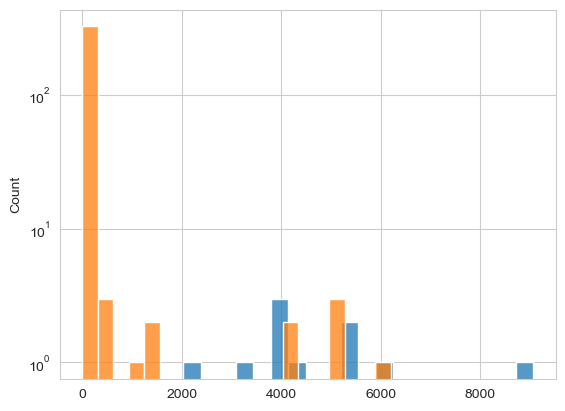

In [120]:
reln_expression = ct_composition[:, cell_types.tolist().index("Exc RELN CHD7")]
sns.histplot(reln_expression[pd.Series(DONORS).isin(OUTLIERS)], bins=20)
sns.histplot(reln_expression[~pd.Series(DONORS).isin(OUTLIERS)], bins=20)
plt.yscale("log")
plt.show()

<Axes: xlabel='cogdx'>

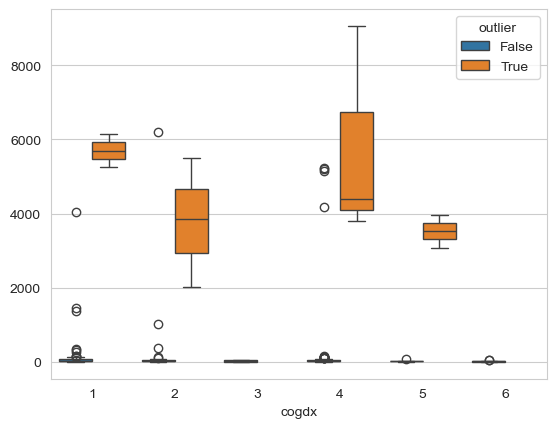

In [126]:
# plot reln expression vs label
sns.boxplot(x="cogdx", y=reln_expression, data=df, hue="outlier")

c:\Users\timo\.conda\envs\pyg\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\timo\.conda\envs\pyg\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


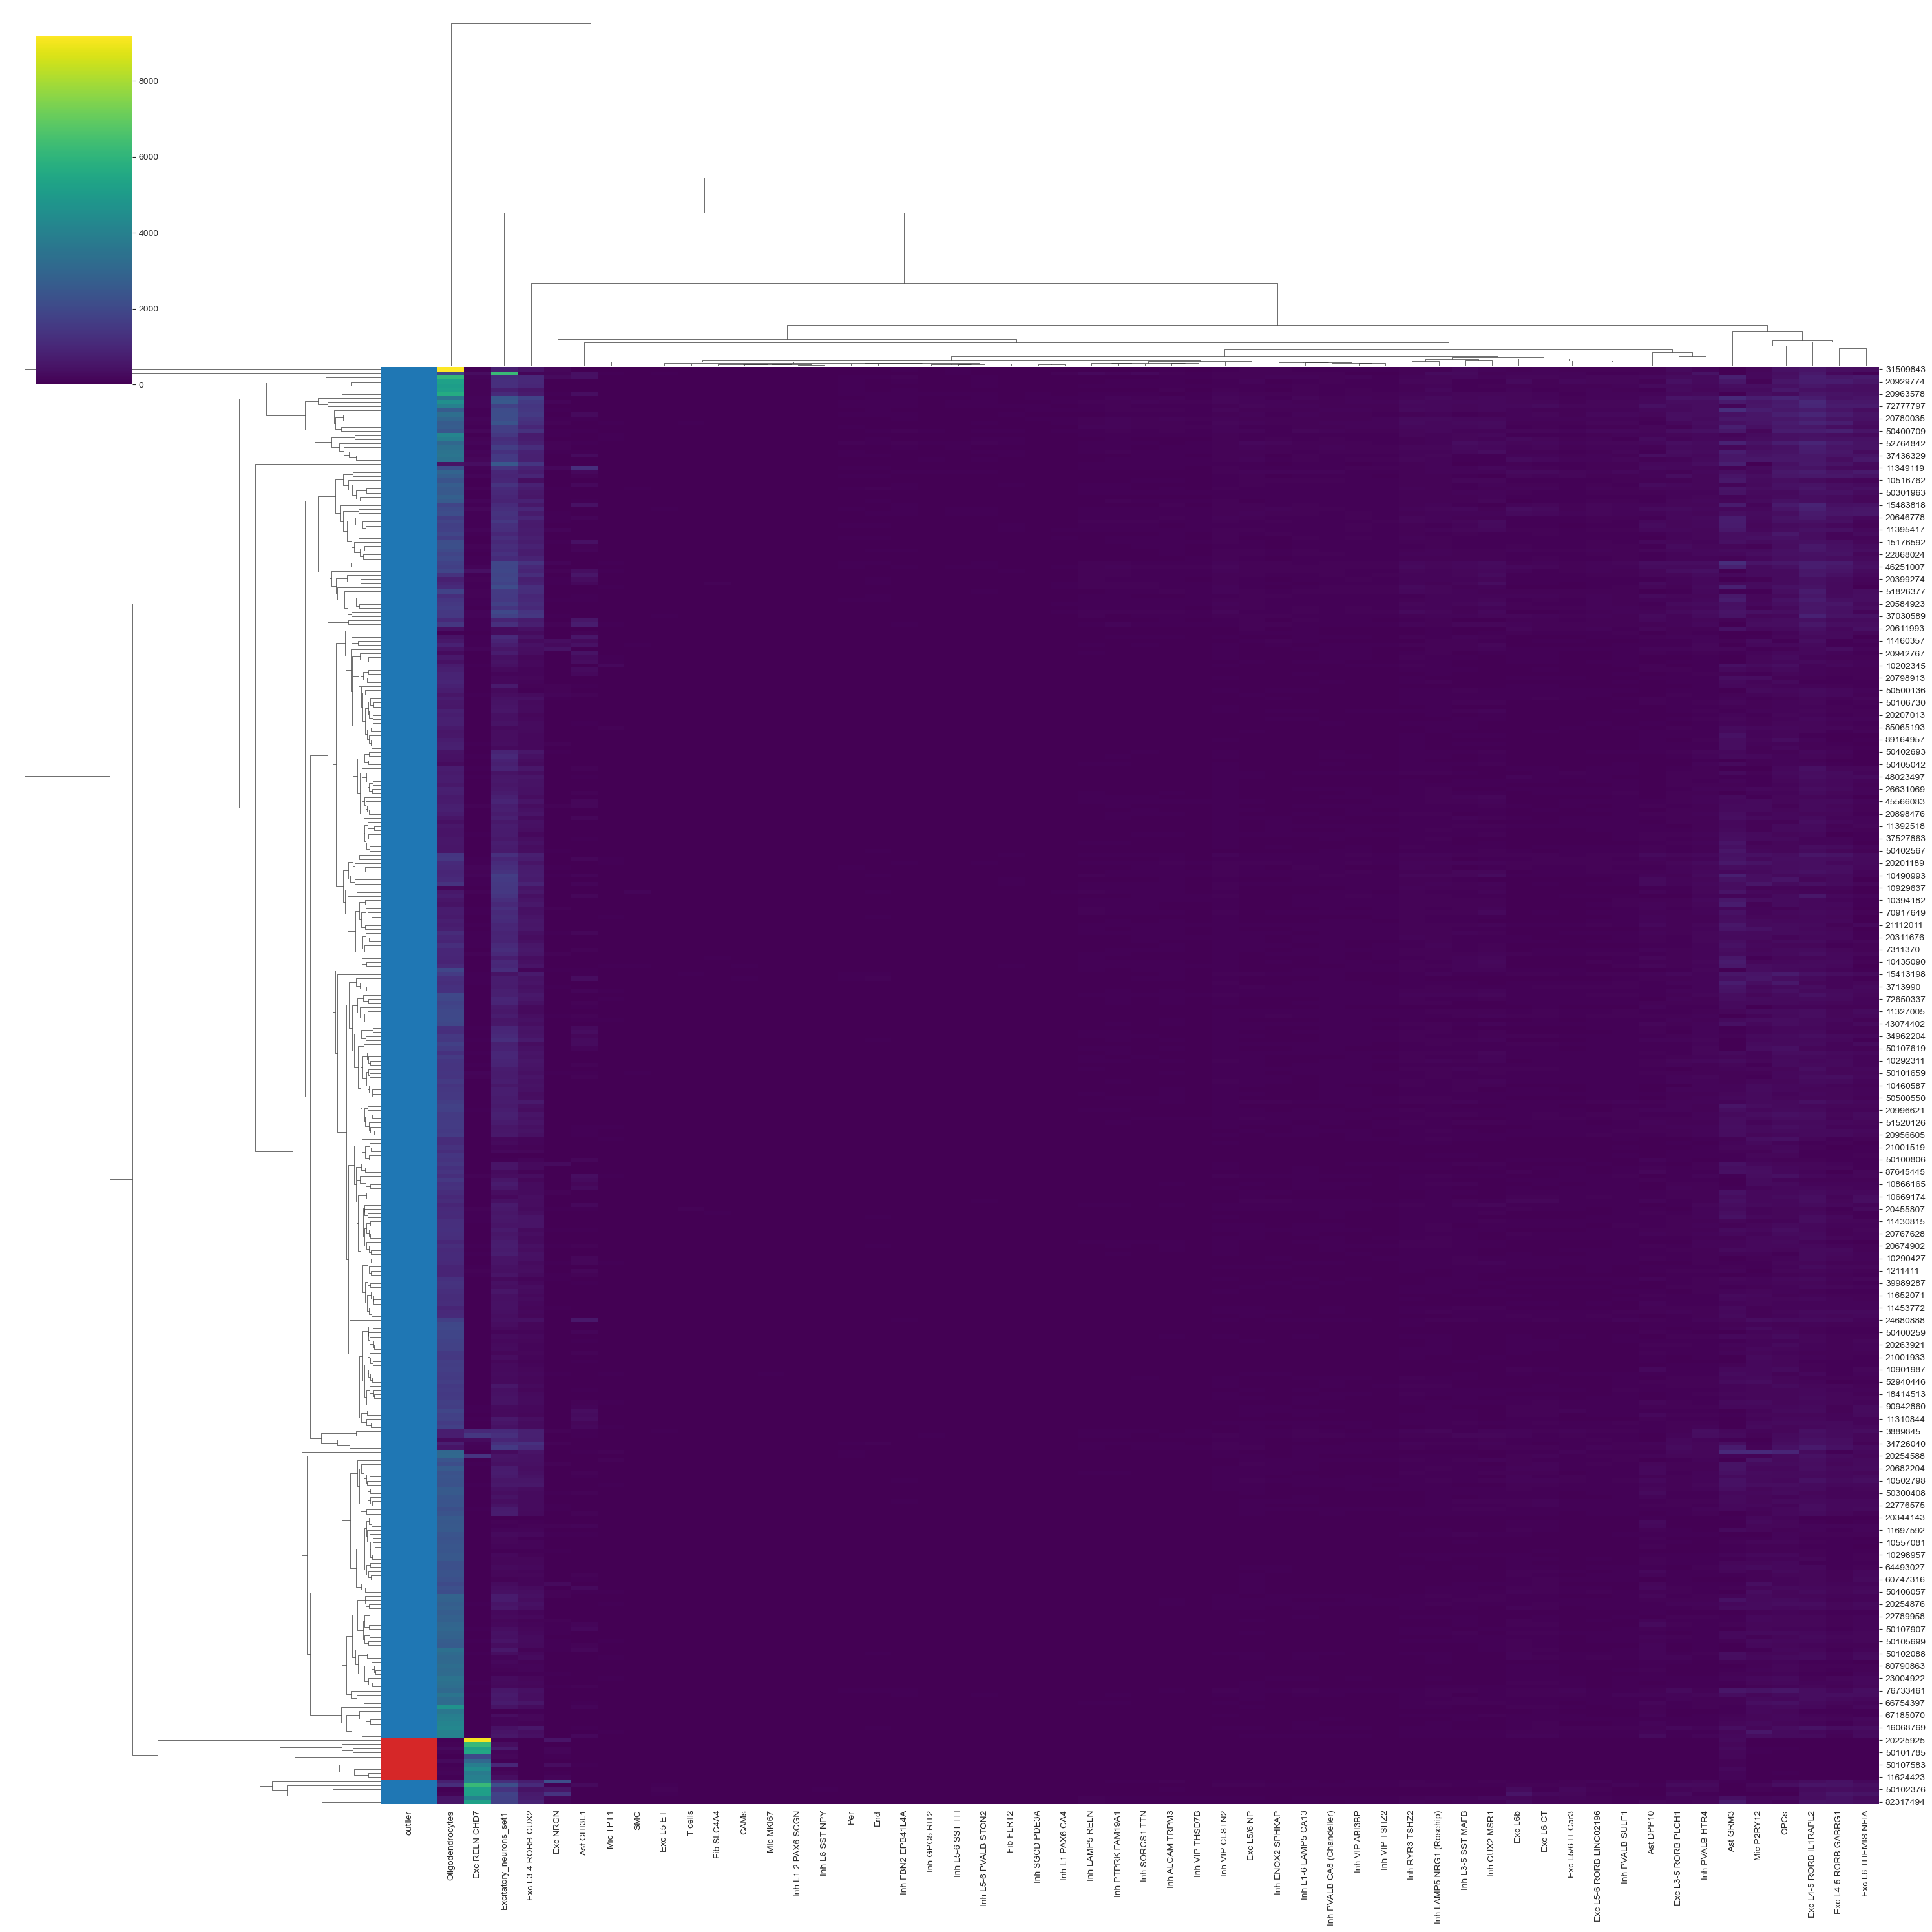

In [103]:
ct_df = pd.DataFrame(ct_composition, 
                     index=DONORS, columns=cell_types)

colors = {True: "#d62728", False: "#1f77b4"}
sns.clustermap(ct_df, cmap="viridis", row_colors=ddata["outlier"].map(colors), figsize=(30, 30))

# sns.clustermap(ct_df, cmap="viridis", row_colors=pd.Series(DONORS_WANG).isin(OUTLIERS), figsize=(5, 50))
# plt.imshow(ct_composition, aspect="auto", cmap="viridis")

UMAP(n_neighbors=5, verbose=True)
Thu Apr 25 15:13:23 2024 Construct fuzzy simplicial set
Thu Apr 25 15:13:24 2024 Finding Nearest Neighbors
Thu Apr 25 15:13:24 2024 Finished Nearest Neighbor Search
Thu Apr 25 15:13:24 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Apr 25 15:13:25 2024 Finished embedding


<Axes: >

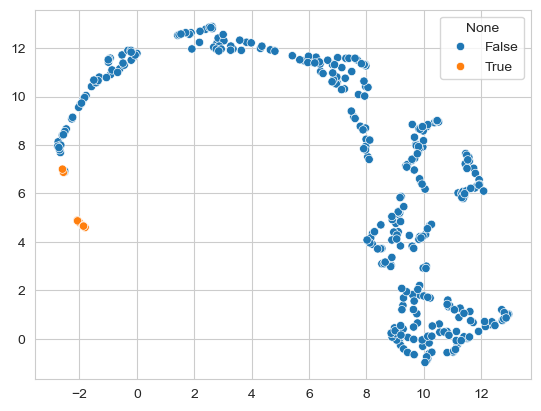

In [38]:
# PCA and UMAP it
pca = PCA(n_components=min(50, len(cell_types)))
umap = UMAP(n_components=2, verbose=True, n_neighbors=5)

ct_composition_pca = pca.fit_transform(ct_composition)
ct_composition_umap = umap.fit_transform(ct_composition_pca)

# plot
sns.scatterplot(x=ct_composition_umap[:, 0], y=ct_composition_umap[:, 1], hue=pd.Series(DONORS).isin(OUTLIERS))

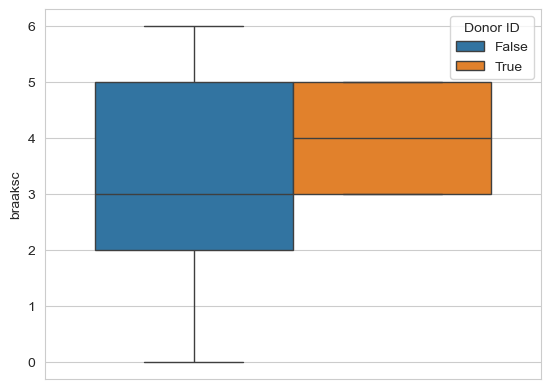

In [23]:
# Try to find what metadata cause the outliers
meta = adata.obs

sns.boxplot(y="braaksc", data=meta, hue=meta["Donor ID"].isin(OUTLIERS))
plt.show()